# Model Interpretations with Captum

Here we take a look at model interpretation with Captum.

Captum provides a common interface to many state of the art means of interpreting **why** a model made the decision that it did.

The type of analysis that Captum automates for us is a crucial step in any machine learning pipeline, and more generally, is a means of gaining some **explainability** for our model.

Model explainability analysis takes place at multiple stages of the machine learning pipeline, including
* During training to evaluate how well different models and hyperparameter choices will generalize
* During testing to validate that a model has learned generalizable features before deploying to production
* During deployment to analyze decisions that were provided to users

## Imports

Here we import required libraries. Notice some new dependencies on `captum.attr`. This module provides a number of state of the art attribution algorithms.

Here we will look at Integrated Gradients and Occlusion. You can learn more about the many attribution techniques offered by captum [here](https://captum.ai/docs/attribution_algorithms).

In [1]:
import torch

# Model building
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Data loading
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2

# Interpretability
from captum.attr import (
    IntegratedGradients,
    Occlusion,
)
from captum.attr import visualization as viz

# Python
import json
from dataclasses import dataclass


import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## MNIST Example

We will keep to our MNIST example now for fast training during in-class demos.

### Load Data

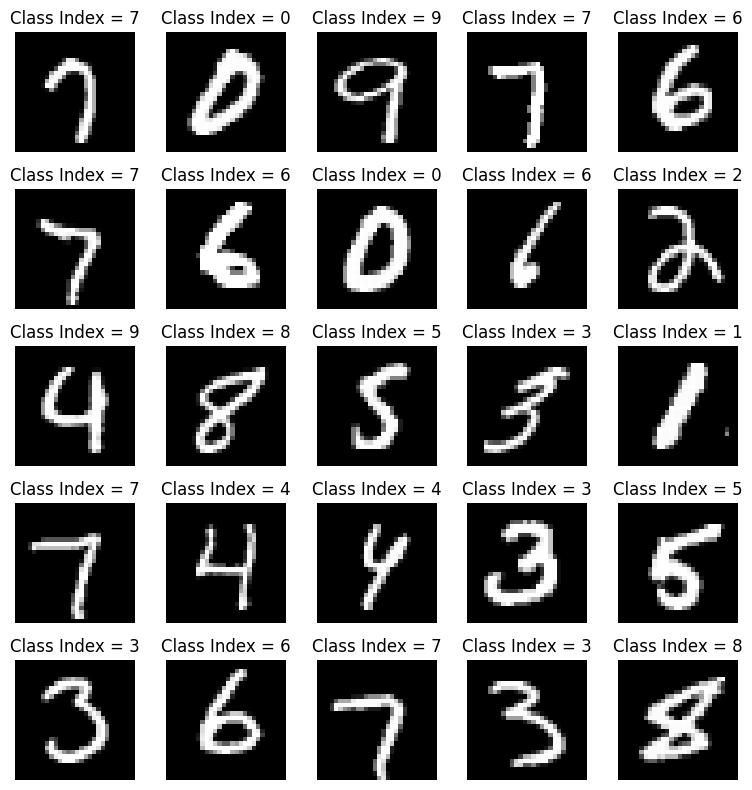

In [2]:
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

dataset = datasets.MNIST(
    root="example_data", download=True, transform=transform
)


def show_images(dataset):
    figure = plt.figure(figsize=(8, 8))
    columns, rows = 5, 5
    for index in range(1, columns * rows + 1):
        sample_index = torch.randint(len(dataset), size=(1,)).item()
        image, label = dataset[sample_index]
        figure.add_subplot(rows, columns, index)
        plt.axis("off")
        plt.imshow(image.permute(1, 2, 0).squeeze(), cmap="gray")
        plt.title("Class Index = {}".format(label))
        plt.tight_layout()
    plt.show()


show_images(dataset)

### Train-Test Split

In [3]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Define a Model Trainer

In [4]:
@dataclass
class TrainingParameters:
    """Training parameters for a simple neural network trainer."""

    epochs: int = 3
    lr: float = 1.0
    gamma: float = 0.7
    dry_run: bool = False
    seed: int = 1
    save_model: bool = True


def predict(model, device, test_loader):
    """Make inferences using a given model and device, on a test set."""
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction="sum").item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )


def run_training_epoch(
    training_params, model, device, train_loader, optimizer, epoch
):
    """Execute a single training epoch."""
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if training_params.dry_run:
            break
        if batch_index % round(len(train_loader) / 79 + 1) == 0:
            print(".", end="")
    print("")
    print("Train Epoch: {} \tLoss: {:.6f}".format(epoch, loss.item()))

    if training_params.save_model:
        torch.save(model.state_dict(), "models/mnist_cnn.pt")


def train(model, training_params, device, train_loader, test_loader):
    """Cycle through epochs to train the given model."""
    optimizer = optim.Adadelta(model.parameters(), lr=training_params.lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=training_params.gamma)

    for epoch in range(1, training_params.epochs + 1):
        run_training_epoch(
            training_params, model, device, train_loader, optimizer, epoch
        )
        predict(model, device, test_loader)
        scheduler.step()

### Define a Model

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        y = F.log_softmax(x, dim=1)
        return y

### Train

In [6]:
model = SimpleCNN().to(device)
training_params = TrainingParameters(epochs=1, dry_run=False)
train(model, training_params, device, train_loader, test_loader)

...........................................................................
Train Epoch: 1 	Loss: 0.015588

Test set: Average loss: 0.0671, Accuracy: 11759/12000 (98%)



## Interpret with Integrated Gradients

Here we will interpret the model with integrated gradients. Integrated gradients, introduced in 2017 by Sundarajan et al., is one of the most important feature attribution methods in the modern literature.

At a high level, integrated gradients works by computing the *integral* of the *gradient* at the output of the model with respect to each input. This tells us how dramatic the change in model output would be if that input was changed, and thereby provides a means of *attributing* each input's contribution to the output.

Integrated gradients is a powerful tool because it provides an individual assessment of each input's (each pixel in the case of an image) contribution to each model decision.

Explainability techniques which provide an assessment of why each individual decision was made are called *local* explainability techniques. By contrast, those which provide an assessment the model as a whole are called *global* explainability techniques.

Of the local explainability techniques, integrated gradient's ability to provide a per-input assessment (e.g., contrasted with the assessment over patches of pixels that we will see from occlusion) is powerful, and, as we will see, can make for some intuitive visuals.

You can read more about integrated gradients [here](https://arxiv.org/pdf/1703.01365).

In [7]:
images, labels = next(iter(test_loader))
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [8]:
ig = IntegratedGradients(model)
test_images, test_labels = next(iter(test_loader))
attribution = ig.attribute(test_images, target=test_labels[0])

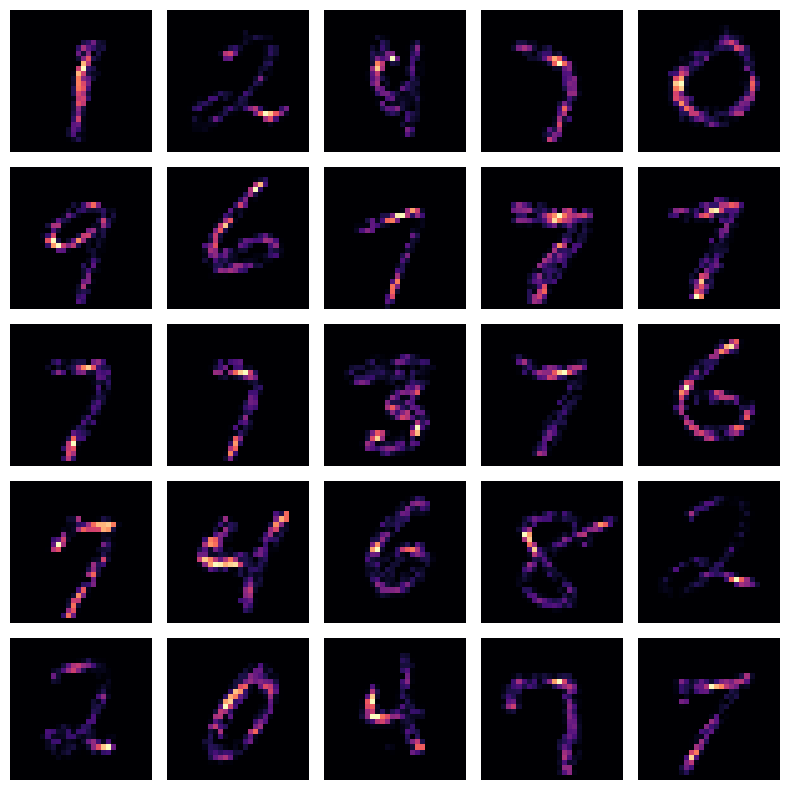

In [9]:
figure = plt.figure(figsize=(8, 8))
columns, rows = 5, 5
for index in range(1, columns * rows + 1):
    sample_index = torch.randint(len(test_images), size=(1,)).item()
    attribution_image = attribution[index].squeeze().detach().numpy()
    figure.add_subplot(rows, columns, index)
    plt.axis("off")
    plt.imshow(np.abs(attribution_image), cmap="magma")
    plt.tight_layout()

## Interpret with Occlusion

Compared to integrated gradients, occlusion simply places a patch of user specified size over various portions of each image and computes how much the output of the model changed.

This provides a per-region assessment of where the model is "looking" to make each decision.

Occlusion is another local explainability technique that complements integrated gradients' ability to provide per-pixel explanations by providing explanations across user-defined regions.

In [10]:
ig = Occlusion(model)
test_images, test_labels = next(iter(test_loader))
attribution = ig.attribute(
    test_images,
    strides=(1, 4, 4),
    target=test_labels[0],
    sliding_window_shapes=(1, 4, 4),
)

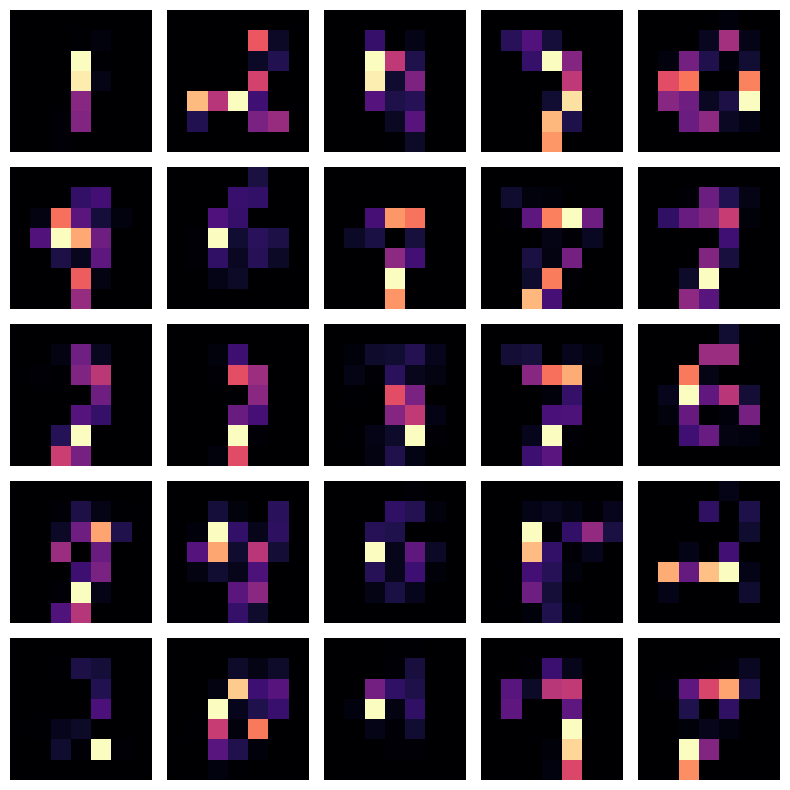

In [11]:
figure = plt.figure(figsize=(8, 8))
columns, rows = 5, 5
for index in range(1, columns * rows + 1):
    sample_index = torch.randint(len(test_images), size=(1,)).item()
    attribution_image = attribution[index].squeeze().detach().numpy()
    figure.add_subplot(rows, columns, index)
    plt.axis("off")
    plt.imshow(np.abs(attribution_image), cmap="magma")
    plt.tight_layout()

## Captum Examples

The following additional examples are provided by Captum's documentation. These and other examples can be found in the captum tutorial [here](https://pytorch.org/tutorials/beginner/introyt/captumyt.html). A long list of exciting tutorials can be found [here](https://captum.ai/tutorials/).

In [12]:
resnet_model = models.resnet101(pretrained=True)
resnet_model = resnet_model.eval()

/workspaces/fall-2024-class-05/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspaces/fall-2024-class-05/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /home/developer/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:06<00:00, 27.5MB/s] 


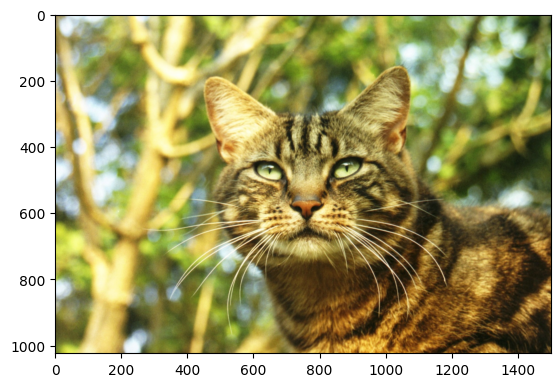

In [13]:
test_img = Image.open("example_data/captum_examples/cat.jpg")
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

In [14]:
# model expects 224x224 3-color image
transform = v2.Compose(
    [
        v2.Resize(224),
        v2.CenterCrop(224),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

# standard ImageNet normalization
transform_normalize = v2.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(
    0
)  # the model requires a dummy batch dimension

labels_path = "example_data/captum_examples/imagenet_class_index.json"
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [15]:
output = resnet_model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print(
    "Predicted:", predicted_label, "(", prediction_score.squeeze().item(), ")"
)

Predicted: tabby ( 0.6249904036521912 )


## Integrated Gradients

In [16]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(resnet_model)

# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(
    input_img, target=pred_label_idx, n_steps=30
)

Captum provides helpful visualization routines that can be useful to employ instead of writing our own.

Here we use `visualize_image_attr`. You can read about the arguments for these routines [here](https://captum.ai/api/utilities.html).

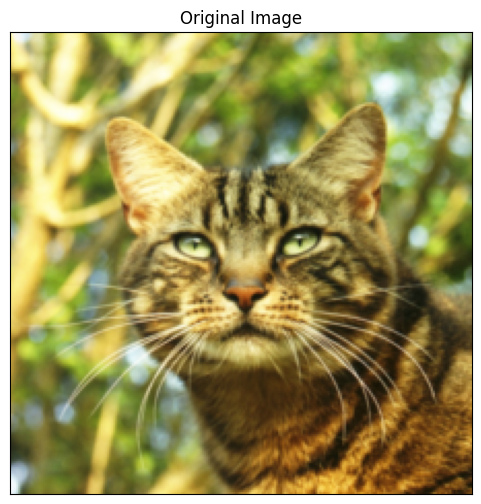

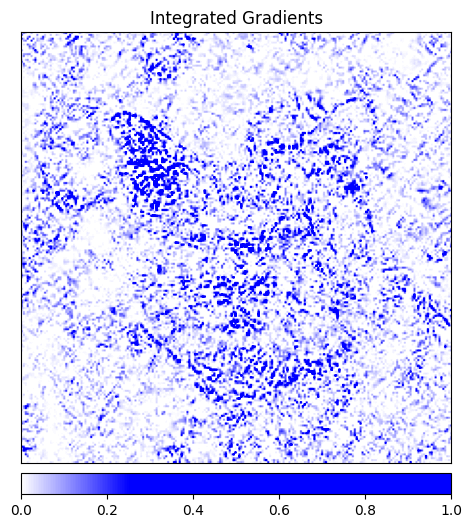

In [17]:
# Show the original image for comparison
_ = viz.visualize_image_attr(
    None,
    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    method="original_image",
    title="Original Image",
)

default_cmap = LinearSegmentedColormap.from_list(
    "custom blue", [(0, "#ffffff"), (0.25, "#0000ff"), (1, "#0000ff")], N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    method="heat_map",
    cmap=default_cmap,
    show_colorbar=True,
    sign="positive",
    title="Integrated Gradients",
)

## Occlusion

In [18]:
occlusion = Occlusion(resnet_model)

attributions_occ = occlusion.attribute(
    input_img,
    target=pred_label_idx,
    strides=(3, 8, 8),
    sliding_window_shapes=(3, 15, 15),
    baselines=0,
)

We can also employ multiple visualization methods at once using `visualize_image_attr_multiple`.

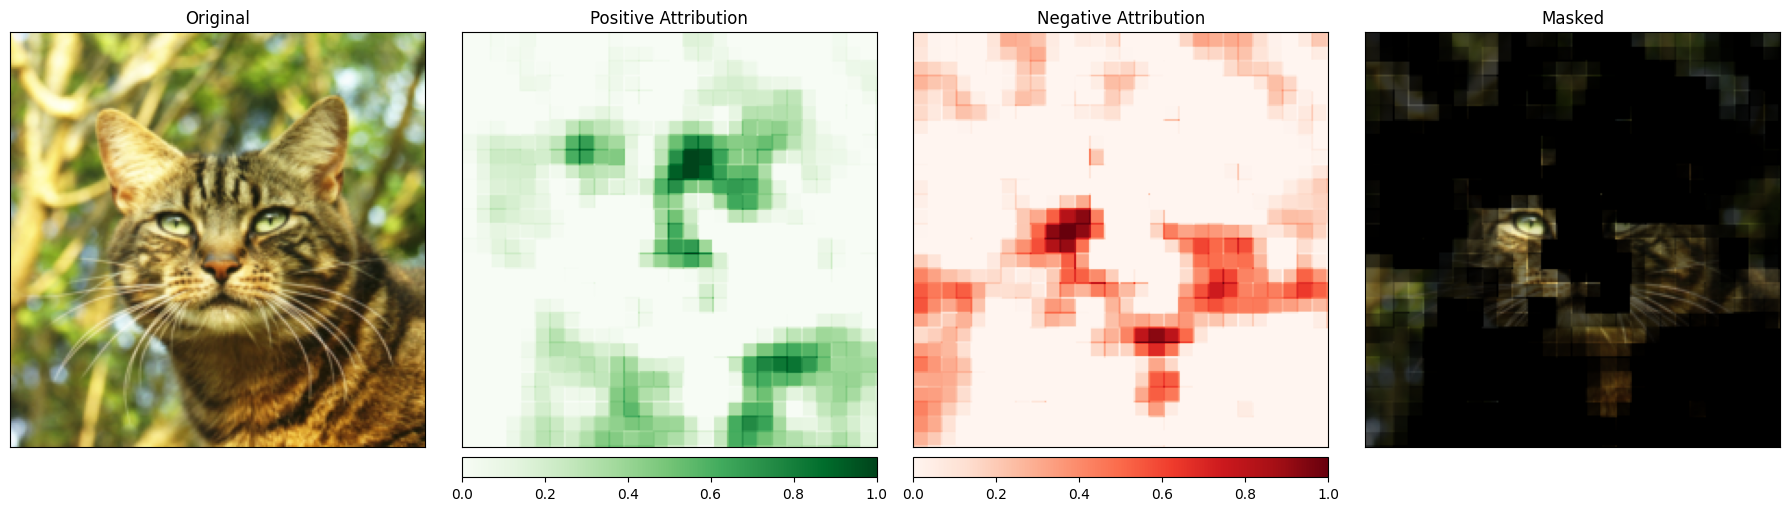

In [19]:
_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    ["original_image", "heat_map", "heat_map", "masked_image"],
    ["all", "positive", "negative", "negative"],
    show_colorbar=True,
    titles=[
        "Original",
        "Positive Attribution",
        "Negative Attribution",
        "Masked",
    ],
    fig_size=(18, 6),
)